## Imports

In [1]:
import scipy.io, random
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

## Utils

In [65]:
def plot_forecast(source, prediction, nrow=5, ncol=5, from_=2800, to_=None):
    n = source.shape[0]
    idx = list(range(n))
    fig, axs = plt.subplots(nrow, ncol, figsize=(15,8), sharex=True)
    if to_ is None:
        to_ = source.shape[1]
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            axs[r,c].plot(source[idx[i], from_:to_], c='b')
            axs[r,c].plot(prediction[idx[i], from_:to_], c='r')

            i += 1
    fig.tight_layout()
    plt.show()

In [ ]:
def plot_shape_function(d, F1, F2, nrow=5, ncol=5):
    n = F1.shape[1]
    idx = random.sample(range(n), nrow * ncol)
    fig, axs = plt.subplots(nrow, ncol, figsize=(15,8), sharex=True)
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            if F2 is not None:
                axs[r,c].scatter(d, F1[:, idx[i]], c='b')
                axs[r,c].scatter(d, F2[:, idx[i]], c='r')
            else:
                axs[r,c].scatter(d, F1[:, idx[i]])
            i += 1
    fig.tight_layout()
    plt.show()

In [ ]:
def scale(X, max_, min_):
    X_std = (X - X.min(axis=1).reshape(-1,1)) / ((X.max(axis=1) - X.min(axis=1)).reshape(-1,1))
    X_std = X_std * (max_ - min_) + min_
    return X_std

In [ ]:
def normalize(X):
    X_std = (X - X.mean(1).reshape(-1, 1)) / X.std(1).reshape(-1, 1)
    return X_std

## Init

In [2]:
ids, d, _ = load_pickle('data/sample.pickle')

In [ ]:
df = pd.read_csv('data/nst_sim_data.csv')
data = df.iloc[:, 1:].to_numpy()

In [ ]:
data_std = normalize(data)

In [ ]:
#  Check data pattern
i = 10
plt.figure(figsize=(20,10))
# plt.plot(data[i, :])
plt.plot(data_std[i, :])

# Stationary

## 1. Forecasting

In [ ]:
sim[0].shape, sim[1].shape, sim[2].shape

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(sim[0][10, -200:], c='b')
plt.plot(sim[1][10, -200:], c='r')

plt.show()

In [ ]:
plot_forecast(sim[0], sim[1], 6, 5, 0, 3000)

## 2. Shape Function

In [ ]:
d_norm = d
F = np.log(d_norm+1)

In [ ]:
l = 200
plt.figure(figsize=(20,10))
plt.scatter(d_norm[:l], F[:l, ], c='b')
plt.scatter(d_norm[:l], sim[2][:l, 0], c='r')
plt.show()

In [ ]:
plot_shape_function(d_norm, sim[2], None, 5, 5)

# Non-Stationary

In [158]:
out = load_pickle('output/nst_sim_500.pickle')
F = np.log(d+1)
N, T = out[0].shape

## 1. Forecasting

In [ ]:
plt.figure(figsize=(20,8))
i = 10
plt.plot(out[0][i, :], c='b')
plt.plot(out[1][i, :], c='r')


plt.show()

In [ ]:
plot_forecast(out[0], out[1], 6, 5, 0, T)

## 2. Shape function

In [160]:
F_hat, mus, alphas = out[2:]

In [ ]:
F_hat

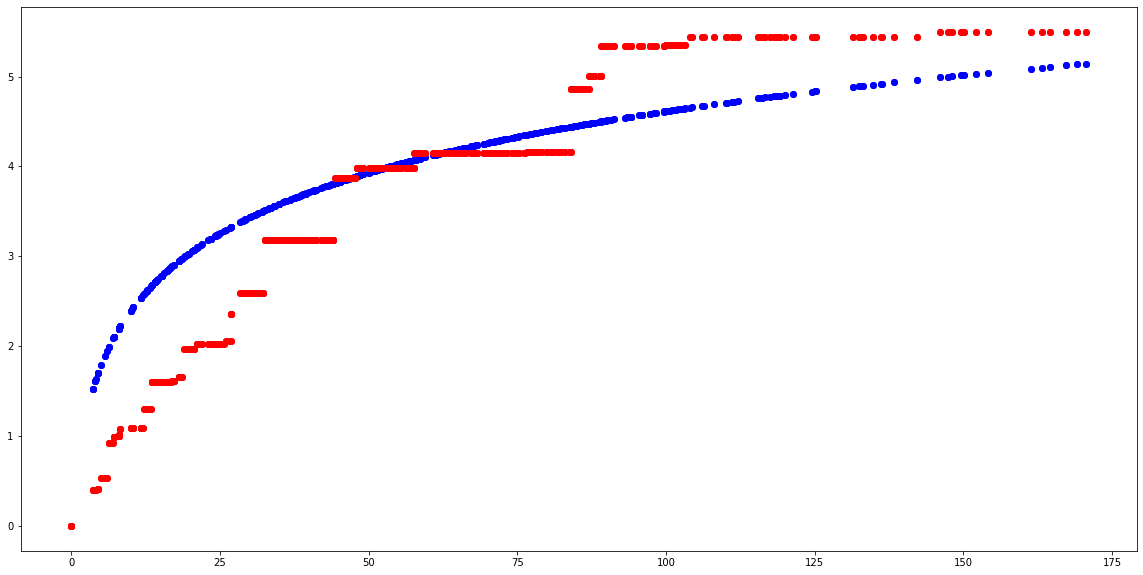

In [161]:
plt.figure(figsize=(20,10))
plt.scatter(d, F, c='b')
plt.scatter(d, F_hat, c='r')
plt.show()

In [98]:
# Compare mus
true_mus = pd.read_csv('data/nst_mu.csv')
true_mus = true_mus.iloc[:, 1:T+1].to_numpy()

In [99]:
true_mus = true_mus.transpose() # / (np.arange(1, T+1) **2)

In [101]:
np.abs(mus - true_mus).mean()

2.88653249847048

In [103]:
true_mus.shape

(100, 30)

In [104]:
true_mus[:10, 0].round(3), mus[:10, 0].round(3)

(array([0.001, 0.003, 0.006, 0.011, 0.017, 0.025, 0.034, 0.045, 0.057,
        0.07 ]),
 array([0.047, 0.228, 0.306, 0.361, 0.442, 0.496, 0.614, 0.682, 0.84 ,
        0.921], dtype=float32))

# Baselines

In [ ]:
dataset = 'sim'
horizon = 1

In [ ]:
data = np.load(f'data/{dataset}.npy')
loc, n = data.shape
print(loc, n)

In [ ]:
#  Scale data and horizon
# data = scale(data, 0.3, 0)

In [ ]:
x_offsets = np.sort(np.concatenate((np.arange(1-horizon, 1, 1),)))
y_offsets = np.sort(np.arange(1, 1+horizon, 1))
x_ids, y_ids = [], []
min_t = abs(min(x_offsets))
max_t = abs(n - abs(max(y_offsets)))  # Exclusive
for t in range(min_t, max_t):
    x_ids.extend(t + x_offsets)
    y_ids.extend(t + y_offsets)

In [ ]:
def aggregate(v, n=7320, h=20, loc=30):
    out = [np.zeros((1, loc)) for _ in range(n)]
    cnt = [np.ones((1, loc)) for _ in range(h)] + [np.zeros((1, loc)) for _ in range(n-h)]
    L = len(y_ids)
    for l in range(L):
        i = y_ids[l] 
        out[i] += v[l, :]
        cnt[i] += 1

    outs = np.concatenate(out)
    cnts = np.concatenate(cnt)
    return (outs/cnts).transpose()

In [ ]:
def load_outputs(path, n, h, loc):
    data = np.load(path)
    input, pred, label = data['input'], data['prediction'], data['truth']
    
    
    if 'DC-RNN' in path:
        pred, label = pred.swapaxes(0,1), label.swapaxes(0,1)
        
    predictions = aggregate(pred.reshape(-1, loc), n, h, loc)
    labels = aggregate(label.reshape(-1, loc), n, h, loc)
#     print(input.shape, pred.shape, label.shape, '//', predictions.shape, labels.shape)
    
    return predictions, labels

## Visualization

In [ ]:
def compute_metrics(name, p, l, horizon, size = None):
    if size:
        p = p[:, -size:]
        l = l[:, -size:]
    # Mean absolute error
    mae = (np.abs(p - l) / horizon).mean()

    # Mean Absolute Percentage Error
    smape = 2.0 * (np.abs(l-p)/(np.abs(l+1e-10)+np.abs(p+1e-10))).mean()

    # Root Mean Squared Error
    rmse = ((p - l)**2 / horizon).mean(-1)
    rmse = np.sqrt(rmse).mean()


    return mae, smape, rmse

In [ ]:
def get_result(i, horizon, collector):
    
    for name in names:
        p, l = load_outputs(f'{name}/data/{dataset}/output/preds{i}.npz', n, horizon, loc)
        out = compute_metrics(name, p, l, horizon)
        collector[name]['mae'].append(out[0])
        collector[name]['smape'].append(out[1])
        collector[name]['rmse'].append(out[2])
    return collector

In [ ]:
names = ['DC-RNN', 'FC-GAGA', 'GMAN', 'ConvLSTM']
collector = {}
for name in names:
    collector[name] = {"mae": [], "smape": [], "rmse": []}

In [ ]:
for i in tqdm(range(100)):
    collector = get_result(i, horizon, collector)    

In [ ]:
for name in names:
    mae = np.array(collector[name]['mae']).mean()
    smape = np.array(collector[name]['smape']).mean()
    rmse = np.array(collector[name]['rmse']).mean()
    print(f"{name} & {mae:.4f} & {smape:.4f} & {rmse:.4f} \\\\")

In [ ]:
mae, smape, rmse = 0, 0, 0
iter = range(100)
for i in tqdm(iter):
    p = np.load(f'output/st_sim/preds{i}.npy')
    l = pd.read_csv(f'data/st_sim/csv/s{i}.csv')
    l = l.iloc[:, 1:].to_numpy()
    a, b, c = compute_metrics('Shape function', p, l , horizon)
    mae += a
    smape += b
    rmse += c

mae /= len(iter)
smape /= len(iter)
rmse /= len(iter)
print(f"Shape function & {mae:.4f} & {smape:.4f} & {rmse:.4f} \\\\")

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(18,8))
i = 0
location = 10
for r in range(2):
    for c in range(2):
        axs[r,c].plot(labels[i][location, -200:], color='blue')
        axs[r,c].plot(preds[i][location, -200:], color='red')
        axs[r,c].title.set_text(names[i])
        i += 1


In [ ]:
plt.figure(figsize=(18,8))
plt.plot(sim[0][location, -200:], c='b')
plt.plot(sim[1][location, -200:], c='r')
plt.show()